## NEW CODE

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import random
import math
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



2023-09-30 01:34:02.420545: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-30 01:34:02.421603: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 01:34:02.443235: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 01:34:02.443740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 01:34:02.834349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Function to read edges from a CSV file and return them as a dictionary
def read_edges_from_csv(csv_file):
    edges_dict = {}
    with open(csv_file, mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            source_node = int(row[0])
            destination_nodes = [int(dest) for dest in row[1:] if dest.strip()]
            if destination_nodes:
                edges_dict[source_node] = destination_nodes
    return edges_dict

In [3]:
def create_graph_from_edges(edges_dict):
    G = nx.DiGraph()
    for source, destination_list in edges_dict.items():
        G.add_edges_from([(source, dest) for dest in destination_list])
    return G

In [4]:

def calculate_features(G, edge_list):
    common_neighbors = []
    jaccard_coefficient = []
    adamic_adar_coefficient = []
    resource_allocation_index = []
    sorenson_index = []
    total_followers = []
    friends_measure = []
    in_degree = []  # New feature: In-degree of source node
    out_degree = []  # New feature: Out-degree of source node
    transitive_friends = []  # New feature: Transitive friends
    edge_rank = []  # New feature: Edge rank
    
    G_undirected = G.to_undirected()
    
    for source, destination in edge_list:
        if G.has_node(source) and G.has_node(destination):
            # Common Neighbors (convert to undirected for this calculation)
            common_neighbor_nodes = list(nx.common_neighbors(G_undirected, source, destination))
            common_neighbors.append(len(common_neighbor_nodes))
            
            # Jaccard Coefficient
            if len(common_neighbor_nodes) > 0:
                jaccard_coefficient.append(list(nx.jaccard_coefficient(G_undirected, [(source, destination)]))[0][2])
            else:
                jaccard_coefficient.append(0.0)  # Set to 0 when there are no common neighbors
            
            # Adamic/Adar Index
            if len(common_neighbor_nodes) > 0:
                adamic_adar_coefficient.append(sum(1 / math.log(G.degree(u) + 1) for u in common_neighbor_nodes))
            else:
                adamic_adar_coefficient.append(0.0)  # Set to 0 when there are no common neighbors
            
            # Resource Allocation Index
            if len(common_neighbor_nodes) > 0:
                resource_allocation_index.append(sum(1 / G.degree(u) for u in common_neighbor_nodes))
            else:
                resource_allocation_index.append(0.0)  # Set to 0 when there are no common neighbors
            
            # Sørensen Index (SI)
            if len(common_neighbor_nodes) > 0:
                sorenson_index.append(2 * len(common_neighbor_nodes) / (G.degree(source) + G.degree(destination)))
            else:
                sorenson_index.append(0.0)  # Set to 0 when there are no common neighbors
            
            # Total Followers for Source Node (You can customize this feature as needed)
            total_followers.append(len(G[source]))
            
            # Friends Measure (You can customize this feature as needed)
            friends_measure.append(2 * len(common_neighbor_nodes) / (G.degree(source) + G.degree(destination)))
            
            # In-degree and Out-degree (Directed features)
            in_degree.append(G.in_degree(source))
            out_degree.append(G.out_degree(source))
            
            # Transitive Friends (Directed feature)
            transitive_friends_count = 0
            for neighbor in common_neighbor_nodes:
                if G.has_edge(source, neighbor) and G.has_edge(neighbor, destination):
                    transitive_friends_count += 1
            transitive_friends.append(transitive_friends_count)
            
            # Edge Rank (You can customize this feature as needed)
            edge_rank.append(0.0)  # Placeholder for edge rank
            
        else:
            # If either source or destination node does not exist, append zeros for all features
            common_neighbors.append(0)
            jaccard_coefficient.append(0.0)
            adamic_adar_coefficient.append(0.0)
            resource_allocation_index.append(0.0)
            sorenson_index.append(0.0)
            total_followers.append(0)
            friends_measure.append(0.0)
            in_degree.append(0)  # In-degree of a non-existent node is 0
            out_degree.append(0)  # Out-degree of a non-existent node is 0
            transitive_friends.append(0)  # No transitive friends for non-existent nodes
            edge_rank.append(0.0)  # Placeholder for edge rank

    return common_neighbors, jaccard_coefficient, adamic_adar_coefficient, resource_allocation_index, sorenson_index, total_followers, friends_measure, in_degree, out_degree, transitive_friends, edge_rank


In [5]:
def train_model(X_train, y_train, X_val, y_val):
    model = keras.Sequential([
    keras.layers.Dense(128, activation='Leakyrelu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
  
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    
    # Early stopping to terminate training early if the validation accuracy doesn't improve
    early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    return model, history

In [6]:


# def train_random_forest(X_train, y_train):
#     clf = RandomForestClassifier()
#     clf.fit(X_train, y_train)
#     return clf




In [7]:
# from sklearn.linear_model import LogisticRegression

# def train_logistic_regression(X_train, y_train):
#     clf = LogisticRegression()
#     clf.fit(X_train, y_train)
#     return clf


In [8]:
train_csv_file = 'train.csv'
edges_dict = read_edges_from_csv(train_csv_file)
G_train = create_graph_from_edges(edges_dict)

In [9]:


# Extract all 'source' nodes from edges_dict
all_source_nodes = list(edges_dict.keys())
len(all_source_nodes)

# # Define the size of the subset
subset_size = 15000

# Randomly select a subset of 'source' nodes
subset_nodes = random.sample(all_source_nodes, subset_size)


In [10]:
existing_edges = [(source, dest) for source, destinations in edges_dict.items() for dest in destinations]
#print('length of existing_edges',len(existing_edges))

In [11]:
positive_samples = random.sample(existing_edges, subset_size)

In [12]:

G = nx.DiGraph()

# Add edges from your loaded data
for source, destination_list in edges_dict.items():
    G.add_edges_from([(source, dest) for dest in destination_list])
    
all_nodes = list(G.nodes)

In [13]:
subset_nodes = random.sample(all_source_nodes, subset_size)

In [14]:

# Initialize a list to store the 100 randomly selected vertices
randomly_selected_nodes = []

# Randomly select nodes until you have 100 that are not directly connected to any of the `subset_nodes`
while len(randomly_selected_nodes) < subset_size :
    node = random.choice(all_nodes)
    
    # Check if the selected node is not in the `subset_nodes` and is not directly connected to any node in `subset_nodes`
    if node not in subset_nodes and all(not G.has_edge(sub_node, node) for sub_node in subset_nodes):
        randomly_selected_nodes.append(node)

# `randomly_selected_nodes` now contains 100 vertices that are not directly connected to any vertex in `subset_nodes`


In [15]:
# Initialize an empty list to store the pairs
negative_samples = []

# Check if the two lists have the same length
if len(subset_nodes) == len(randomly_selected_nodes):
    # Iterate through both lists simultaneously and create pairs
    for subset_node, random_node in zip(subset_nodes, randomly_selected_nodes):
        pair = (subset_node, random_node)
        negative_samples.append(pair)
else:
    print("Error: The two lists have different lengths.")

# Print the resulting list of pairs
#print(negative_samples)


In [16]:
balanced_edges = positive_samples + negative_samples

In [17]:
# Calculate features for train data
common_neighbors, jaccard_coefficient, adamic_adar_coefficient, resource_allocation_index, sorenson_index, total_followers, friends_measure, in_degree, out_degree, transitive_friends, edge_rank = calculate_features(G, balanced_edges)



In [18]:
# Combine features into a feature matrix
X_train = np.column_stack((common_neighbors, jaccard_coefficient, adamic_adar_coefficient, resource_allocation_index, sorenson_index, total_followers, friends_measure, in_degree, out_degree, transitive_friends, edge_rank))
y_train = np.array([1] * subset_size + [0] * subset_size)

In [19]:
print(X_train.shape)
print(y_train.shape)

(30000, 11)
(30000,)


In [20]:
import pickle

# Save X_train and y_train to a file
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
import pickle




In [21]:
# Standardize the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [22]:
# # For random Forest method

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# rf_model = train_random_forest(X_train, y_train)

# y_pred = rf_model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# print(f"Random Forest Model Accuracy: {accuracy}")
# print(report)

In [23]:
# #For Logistic Regression method

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# lr_model = train_logistic_regression(X_train, y_train)

# y_pred = lr_model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# print(f"Logistic Regression Model Accuracy: {accuracy}")
# print(report)


In [24]:
# Load X_train and y_train from saved files
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

In [25]:
# Split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Train the model
model, history = train_model(X_train, y_train, X_val, y_val)

Epoch 1/50


2023-09-30 01:50:53.562332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 01:50:53.563971: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


375/375 [==============================] - 1s 1ms/step - loss: 0.3138 - accuracy: 0.8891 - val_loss: 0.2158 - val_accuracy: 0.9198
Epoch 2/50
375/375 [==============================] - 0s 625us/step - loss: 0.2252 - accuracy: 0.9246 - val_loss: 0.1909 - val_accuracy: 0.9300
Epoch 3/50
375/375 [==============================] - 1s 1ms/step - loss: 0.2092 - accuracy: 0.9292 - val_loss: 0.1837 - val_accuracy: 0.9315
Epoch 4/50
375/375 [==============================] - 0s 537us/step - loss: 0.2011 - accuracy: 0.9305 - val_loss: 0.1795 - val_accuracy: 0.9345
Epoch 5/50
375/375 [==============================] - 0s 930us/step - loss: 0.1949 - accuracy: 0.9328 - val_loss: 0.1832 - val_accuracy: 0.9318
Epoch 6/50
375/375 [==============================] - 0s 1ms/step - loss: 0.1895 - accuracy: 0.9332 - val_loss: 0.1762 - val_accuracy: 0.9323
Epoch 7/50
375/375 [==============================] - 0s 997us/step - loss: 0.1900 - accuracy: 0.9340 - val_loss: 0.1717 - val_accuracy: 0.9325
Epoch 8/5

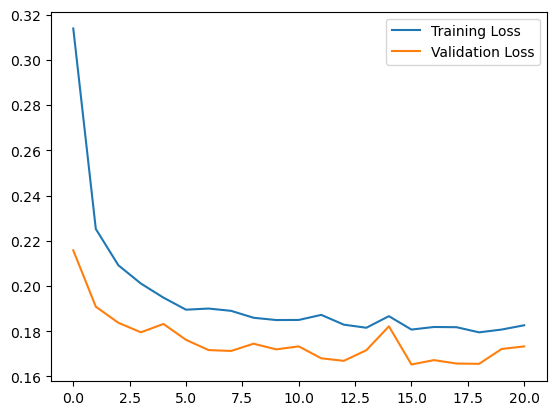

In [26]:
#plot the training and validation loss  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

In [28]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('test.csv')

# Create a list of tuples from the "From" and "To" columns
test_list = [(row['From'], row['To']) for index, row in df.iterrows()]

# Now, pairs_list contains pairs of elements as tuples from "From" and "To" columns
#print(test_list)

In [29]:
# Calculate features for test data
common_neighbors, jaccard_coefficient, adamic_adar_coefficient, resource_allocation_index, sorenson_index, total_followers, friends_measure, in_degree, out_degree, transitive_friends, edge_rank = calculate_features(G, test_list)

# Combine features into a feature matrix
X_test_ts = np.column_stack((common_neighbors, jaccard_coefficient, adamic_adar_coefficient, resource_allocation_index, sorenson_index, total_followers, friends_measure, in_degree, out_degree, transitive_friends, edge_rank))

In [30]:
print(X_test_ts.shape)

(2000, 11)


In [31]:
# Standardize the feature values
scaler = StandardScaler()
X_test_ts_scaled = scaler.fit_transform(X_test_ts)

In [32]:
import pickle

# Save X_train and y_train to a file
with open('X_test_ts.pkl', 'wb') as f:
    pickle.dump(X_test_ts, f)

    
    




In [33]:

with open('X_train.pkl', 'rb') as f:
    X_train_ts = pickle.load(f)


In [34]:
len(X_test_ts)

2000

In [35]:
y_pred=model.predict(X_test_ts_scaled)
#y_pred

63/63 [==============================] - 0s 334us/step


In [36]:
# Save the array to a CSV file.
np.savetxt('prob.csv', y_pred, delimiter=',', fmt='%s')

In [37]:



results = np.column_stack((ids, y_pred))

np.savetxt('predictions.csv', results, delimiter=',', fmt='%f', header='ID,Predictions', comments='')

print("Predictions saved to 'predictions.csv'")


NameError: name 'ids' is not defined

In [38]:
# Assuming you have a list of predicted probabilities stored in 'predicted_probabilities'

# Define a threshold 
threshold = 0.4061

# Initialize a list to store binary predictions
binary_predictions = []

# Convert probabilities to binary predictions
for prob in y_pred:
    if prob > threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

# Now 'binary_predictions' contains your binary predictions


In [ ]:
#binary_predictions

In [39]:
# Convert the list to a NumPy array.
array = np.array(binary_predictions)

# Save the array to a CSV file.
np.savetxt('binary.csv', array, delimiter=',', fmt='%s')

In [40]:
import csv

# Open the CSV file in read mode.
with open('binary.csv', 'r') as f:
    # Create a csv.reader object.
    reader = csv.reader(f)

    # Count the number of 1s and 0s in each row.
    count_1 = 0
    count_0 = 0
    for row in reader:
        for item in row:
            if item == '1':
                count_1 += 1
            elif item == '0':
                count_0 += 1

    # Print the total number of 1s and 0s.
    print('Number of 1s:', count_1)
    print('Number of 0s:', count_0)


Number of 1s: 1993
Number of 0s: 7


In [41]:
ids = np.arange(1, 2001)

 

# Combine IDs and predictions into a single array
results = np.column_stack((ids, y_pred))

 

# Save the array to a CSV file with headers for ID and Predictions
np.savetxt('predictions.csv', results, delimiter=',', fmt='%s', header='ID,Predictions', comments='')

 

print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'
